# Trader Behavior Analysis Under Market Sentiment Regimes
Fear & Greed Index × Hyperliquid Trading Data


# Data Loading

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import os

In [10]:
# Load datasets
historical_path = "historical_data.csv"
sentiment_path = "fear_greed_index.csv"

In [11]:
historical_df = pd.read_csv(historical_path)
sentiment_df = pd.read_csv(sentiment_path)

In [12]:
historical_head = historical_df.head()
historical_head

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [13]:
sentiment_head = sentiment_df.head()
sentiment_head

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [14]:
historical_shape = historical_df.shape
historical_shape

(211224, 16)

In [15]:
sentiment_shape = sentiment_df.shape
sentiment_shape

(2644, 4)

In [16]:
historical_columns = historical_df.columns.tolist()
historical_columns

['Account',
 'Coin',
 'Execution Price',
 'Size Tokens',
 'Size USD',
 'Side',
 'Timestamp IST',
 'Start Position',
 'Direction',
 'Closed PnL',
 'Transaction Hash',
 'Order ID',
 'Crossed',
 'Fee',
 'Trade ID',
 'Timestamp']

In [17]:
sentiment_columns = sentiment_df.columns.tolist()
sentiment_columns

['timestamp', 'value', 'classification', 'date']

# Data Cleaning & Preprocessing

In [18]:
historical_df['Timestamp_IST'] = pd.to_datetime(historical_df['Timestamp IST'], errors='coerce')
historical_df['Timestamp_UTC'] = historical_df['Timestamp_IST'] - timedelta(hours=5, minutes=30)
historical_df['Trade_Date_UTC'] = historical_df['Timestamp_UTC'].dt.date

In [19]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
sentiment_df['Sentiment_Date'] = sentiment_df['date'].dt.date
sentiment_df['classification'] = sentiment_df['classification'].str.lower()

In [20]:
missing_historical = historical_df.isnull().sum()
missing_sentiment = sentiment_df.isnull().sum()

missing_historical, missing_sentiment

(Account                  0
 Coin                     0
 Execution Price          0
 Size Tokens              0
 Size USD                 0
 Side                     0
 Timestamp IST            0
 Start Position           0
 Direction                0
 Closed PnL               0
 Transaction Hash         0
 Order ID                 0
 Crossed                  0
 Fee                      0
 Trade ID                 0
 Timestamp                0
 Timestamp_IST       131999
 Timestamp_UTC       131999
 Trade_Date_UTC      131999
 dtype: int64,
 timestamp         0
 value             0
 classification    0
 date              0
 Sentiment_Date    0
 dtype: int64)

# Dataset Integration

In [21]:
merged_df = pd.merge(
    historical_df,
    sentiment_df[['Sentiment_Date', 'classification', 'value']],
    left_on='Trade_Date_UTC',
    right_on='Sentiment_Date',
    how='left'
)

In [22]:
analysis_df = merged_df[merged_df['classification'].notna()].copy()

In [42]:
os.makedirs("csv_files", exist_ok=True)

# merged_df.to_csv("csv_files/merged_all_trades.csv", index=False)
analysis_df.to_csv("csv_files/merged_sentiment_trades.csv", index=False)

# Feature Engineering

In [24]:
analysis_df['is_profitable'] = analysis_df['Closed PnL'] > 0

In [25]:
trader_metrics = analysis_df.groupby(['Account', 'classification']).agg(
    total_trades=('Trade ID', 'count'),
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_profitable', 'mean'),
    avg_trade_size_usd=('Size USD', 'mean'),
    total_volume_usd=('Size USD', 'sum'),
    avg_fee=('Fee', 'mean')
).reset_index()

trader_metrics.head()

,Account,classification,total_trades,total_pnl,avg_pnl,win_rate,avg_trade_size_usd,total_volume_usd,avg_fee
0,0x083384f897ee0f19899168e3b1bec365f52a9012,extreme fear,392,99958.651460,254.996560,0.533163,23910.855485,9373055.35,2.988280
1,0x083384f897ee0f19899168e3b1bec365f52a9012,extreme greed,177,0.000000,0.000000,0.000000,5089.718249,900880.13,0.948000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,fear,1619,910647.967350,562.475582,0.413836,13220.264009,21403607.43,1.331764
3,0x083384f897ee0f19899168e3b1bec365f52a9012,greed,132,-89418.778615,-677.414990,0.340909,36729.064924,4848236.57,1.954151
4,0x083384f897ee0f19899168e3b1bec365f52a9012,neutral,166,44400.905800,267.475336,0.469880,23733.479458,3939757.59,3.994128


In [26]:
trader_metrics.shape

(114, 9)

In [46]:
trader_metrics.to_csv("csv_files/trader_metrics.csv", index=False)

# Exploratory Data Analysis

In [27]:
os.makedirs("outputs", exist_ok=True)

PnL by Sentiment

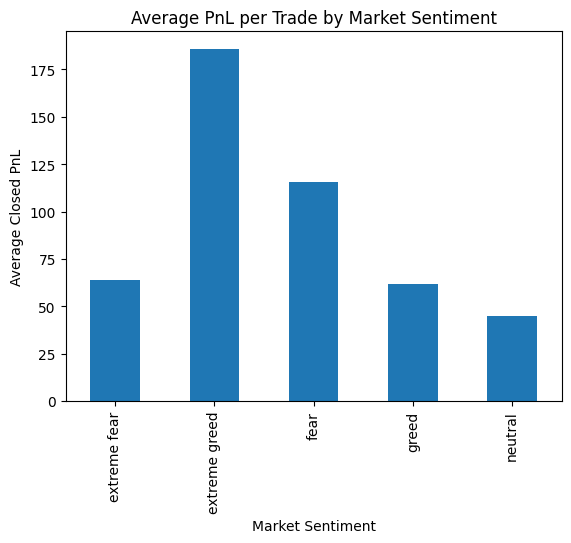

In [28]:
pnl_by_sentiment = analysis_df.groupby('classification')['Closed PnL'].mean()

plt.figure()
pnl_by_sentiment.plot(kind='bar')
plt.title("Average PnL per Trade by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.show()

In [29]:
pnl_by_sentiment

,Closed PnL
classification,
extreme fear,63.967077
extreme greed,185.735746
fear,115.787381
greed,61.962941
neutral,44.717193


Win Rate by Sentiment

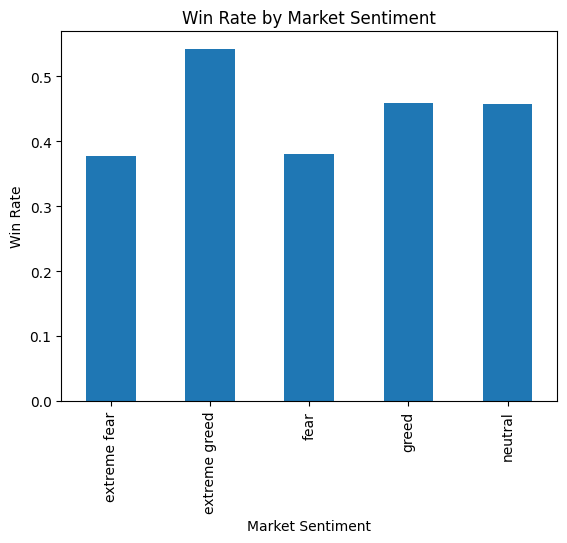

In [30]:
analysis_df['is_profitable'] = analysis_df['Closed PnL'] > 0
winrate_by_sentiment = analysis_df.groupby('classification')['is_profitable'].mean()

plt.figure()
winrate_by_sentiment.plot(kind='bar')
plt.title("Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.savefig("outputs/winrate_by_sentiment.png")
plt.show()

In [31]:
winrate_by_sentiment

,is_profitable
classification,
extreme fear,0.377154
extreme greed,0.541902
fear,0.380490
greed,0.458963
neutral,0.457122


# Advanced Behavioral Insights

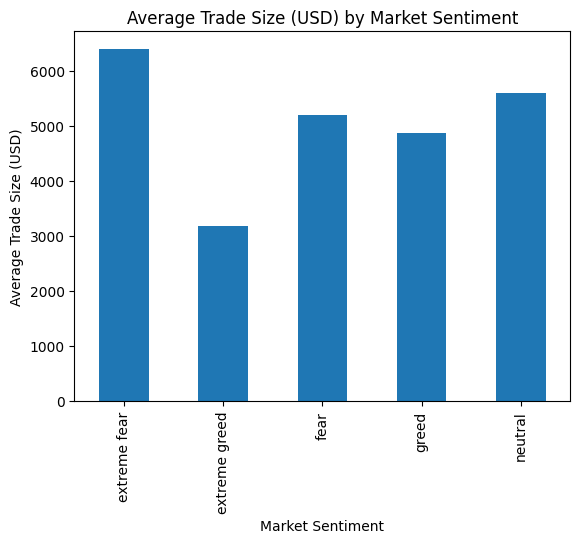

In [43]:
avg_size_by_sentiment = analysis_df.groupby('classification')['Size USD'].mean()

plt.figure()
avg_size_by_sentiment.plot(kind='bar')
plt.title("Average Trade Size (USD) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.savefig("outputs/avg_size_by_sentiment.png")
plt.show()

In [33]:
# Aggregate overall trader performance
trader_overall = analysis_df.groupby('Account').agg(
    total_pnl=('Closed PnL', 'sum'),
    total_trades=('Trade ID', 'count'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()

top_traders = trader_overall.sort_values('total_pnl', ascending=False).head(10)
bottom_traders = trader_overall.sort_values('total_pnl').head(10)

avg_size_by_sentiment

,Size USD
classification,
extreme fear,6400.917359
extreme greed,3186.503350
fear,5206.804921
greed,4879.338891
neutral,5605.800705


In [34]:
top_traders.head()

,Account,total_pnl,total_trades,avg_trade_size
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,1.483142e+06,5277,5068.085878
0,0x083384f897ee0f19899168e3b1bec365f52a9012,9.655887e+05,2486,16277.368089
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,2.574013e+05,2944,4313.861539
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2.151040e+05,5758,1844.130149
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1.972949e+05,283,2591.129470


In [35]:
bottom_traders.head()

,Account,total_pnl,total_trades,avg_trade_size
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,-4158.185452,298,6976.186544
21,0x8477e447846c758f5a675856001ea72298fd9cb5,-2613.560408,2823,875.851877
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,0.000000,141,11569.857730
9,0x430f09841d65beb3f27765503d0f850b8bce7713,0.000000,6,0.548333
2,0x271b280974205ca63b716753467d5a371de622ab,208.817460,4,39530.987500


# More Visualizations

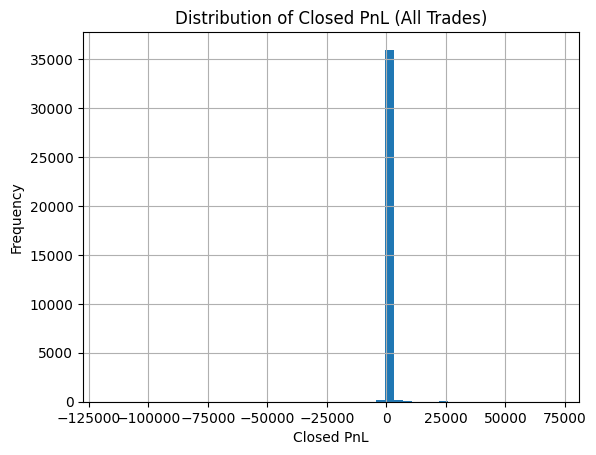

In [44]:
#PnL Distribution
plt.figure()
analysis_df['Closed PnL'].hist(bins=50)
plt.title("Distribution of Closed PnL (All Trades)")
plt.xlabel("Closed PnL")
plt.ylabel("Frequency")
plt.savefig("outputs/pnl_distribution.png")
plt.show()

<Figure size 640x480 with 0 Axes>

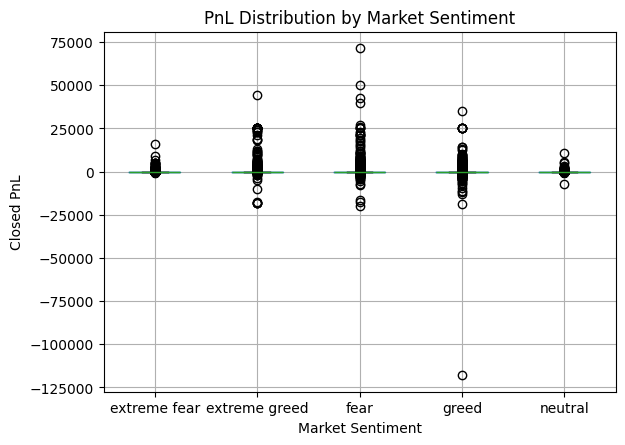

In [37]:
#Boxplot of PnL by Sentiment
plt.figure()
analysis_df.boxplot(column='Closed PnL', by='classification')
plt.title("PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.savefig("outputs/pnl_boxplot.png")
plt.show()

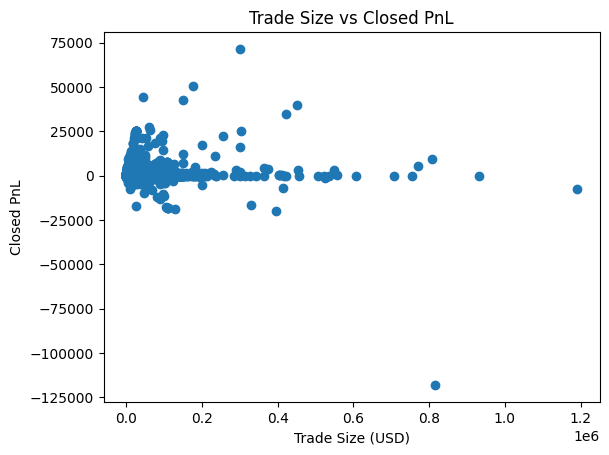

In [38]:
plt.figure()
plt.scatter(analysis_df['Size USD'], analysis_df['Closed PnL'])
plt.title("Trade Size vs Closed PnL")
plt.xlabel("Trade Size (USD)")
plt.ylabel("Closed PnL")
plt.savefig("outputs/trade_size_vs_pnl.png")
plt.show()

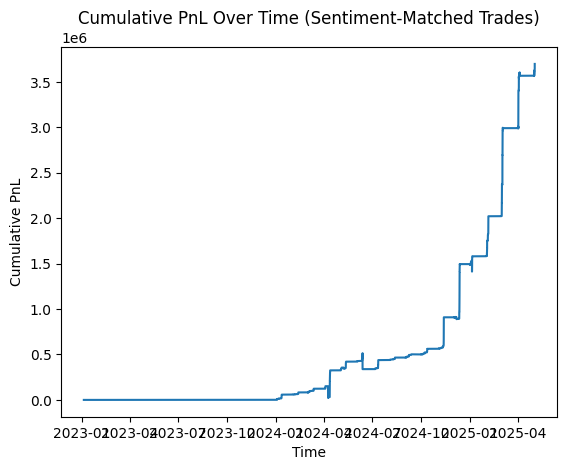

In [39]:
analysis_df_sorted = analysis_df.sort_values('Timestamp_UTC')
analysis_df_sorted['cumulative_pnl'] = analysis_df_sorted['Closed PnL'].cumsum()

plt.figure()
plt.plot(analysis_df_sorted['Timestamp_UTC'], analysis_df_sorted['cumulative_pnl'])
plt.title("Cumulative PnL Over Time (Sentiment-Matched Trades)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.savefig("outputs/cumulative_pnl.png")
plt.show()

/tmp/ipython-input-2885103774.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winrate_by_size = analysis_df.groupby('size_bin')['is_profitable'].mean()


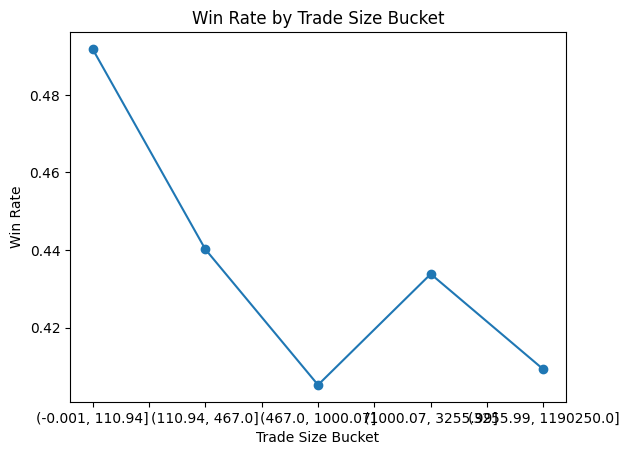

In [45]:
analysis_df['size_bin'] = pd.qcut(analysis_df['Size USD'], q=5, duplicates='drop')
winrate_by_size = analysis_df.groupby('size_bin')['is_profitable'].mean()

plt.figure()
winrate_by_size.plot(kind='line', marker='o')
plt.title("Win Rate by Trade Size Bucket")
plt.xlabel("Trade Size Bucket")
plt.ylabel("Win Rate")
plt.savefig("outputs/winrate_by_Trade_Size.png")
plt.show()

In [41]:
analysis_df[['Closed PnL','Size USD','classification']].describe()

,Closed PnL,Size USD
count,36386.000000,3.638600e+04
mean,101.559141,4.892793e+03
std,1355.136479,2.188974e+04
min,-117990.104100,0.000000e+00
25%,0.000000,1.703950e+02
50%,0.000000,6.036350e+02
75%,11.813000,2.217530e+03
max,71535.716740,1.190250e+06


## Key Takeaways
1. Market sentiment significantly impacts trader profitability and risk exposure
2. Extreme greed favors momentum strategies with controlled sizing
3. Fear regimes show asymmetric payoff opportunities for contrarian traders
4. Consistent profitability is driven by discipline, not trade size
